In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import Product Sales and Weather Data (Mel/Syd)
sales_df = pd.read_csv("../data/ProductsByDate.csv")
weather_mel_df = pd.read_csv("../data/weather_data_mel.csv")
weather_syd_df = pd.read_csv("../data/weather_data_syd.csv")

sales_df.head()
weather_mel_df.head()
weather_syd_df.head()

,date,temperature,humidity,wind_speed
0,03/01/2023,27.82,63.0,14.92
1,23/01/2023,24.83,68.0,8.75
2,26/01/2023,30.94,58.0,9.26
3,29/01/2023,29.70,73.0,8.75
4,01/02/2023,27.28,64.0,9.26


In [2]:
# Merge weather data with product data based on date
mel_combined = pd.merge(sales_df, weather_mel_df, how="inner", left_on="order_date", right_on="date")
mel_combined.drop(columns=["order_date"], inplace=True)
syd_combined = pd.merge(sales_df, weather_syd_df, how="inner", left_on="order_date", right_on="date")
syd_combined.drop(columns=["order_date"], inplace=True)

mel_combined.head()
syd_combined.head()

,product_id,product_category,quantity_sold,date,temperature,humidity,wind_speed
0,2490971,Cold and Flu,22,23/01/2023,24.83,68.0,8.75
1,2490971,Cold and Flu,15,26/01/2023,30.94,58.0,9.26
2,2490971,Cold and Flu,12,29/01/2023,29.70,73.0,8.75
3,2490971,Cold and Flu,14,24/02/2023,24.98,62.0,8.23
4,2490971,Cold and Flu,16,27/02/2023,25.67,73.0,9.26


In [3]:
mel_combined['date'] = pd.to_datetime(mel_combined['date'], format='%d/%m/%Y')
mel_combined['date'] = pd.to_datetime(mel_combined['date'], format='%d/%m/%Y')



In [4]:
# Parse dates
sales_df['Date'] = pd.to_datetime(sales_df['order_date'], format='%d/%m/%Y') 
weather_mel_df['Date'] = pd.to_datetime(weather_mel_df['date'], format='%d/%m/%Y')
weather_syd_df['Date'] = pd.to_datetime(weather_syd_df['date'], format='%d/%m/%Y')

# Add Month and Season
sales_df['Month'] = sales_df['Date'].dt.month
sales_df['Year'] = sales_df['Date'].dt.year
def map_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

sales_df['Season'] = sales_df['Month'].apply(map_season)

# Group by Month and Product
monthly_sales = sales_df.groupby(['Month', 'product_category'])['quantity_sold'].sum().reset_index()

monthly_sales.head()

,Month,product_category,quantity_sold
0,1,Cold and Flu,676
1,1,Cosmetics,165
2,1,Hair Care,545
3,1,Hayfever,3300
4,2,Cold and Flu,627


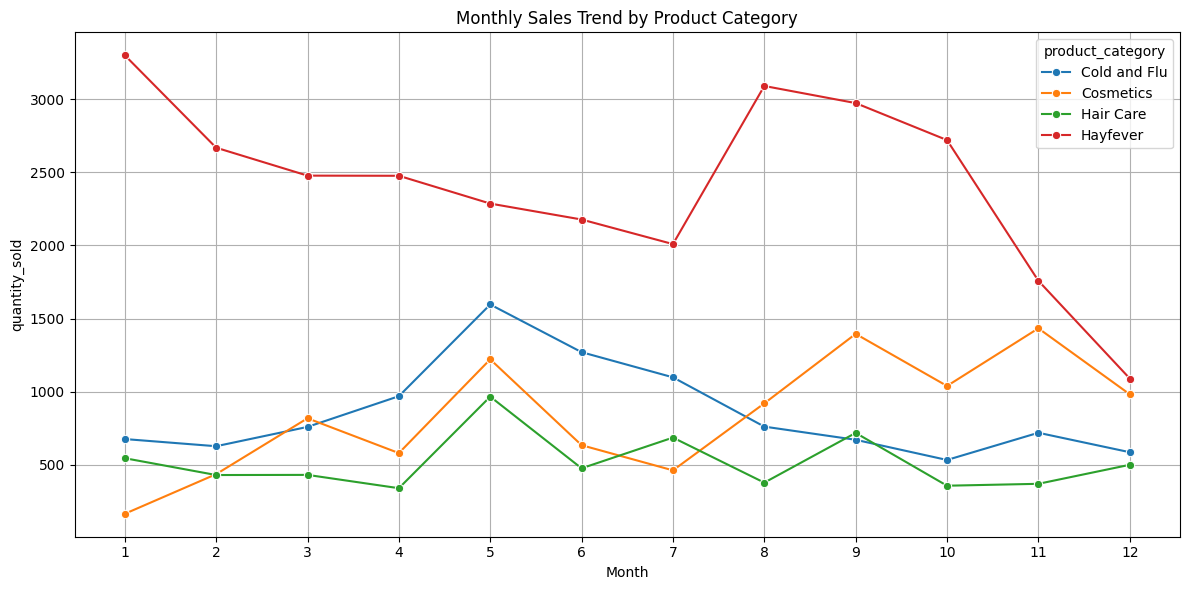

In [6]:
# Insight 1: Product-wise Monthly Sales Trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='quantity_sold', hue='product_category', marker='o')
plt.title('Monthly Sales Trend by Product Category')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

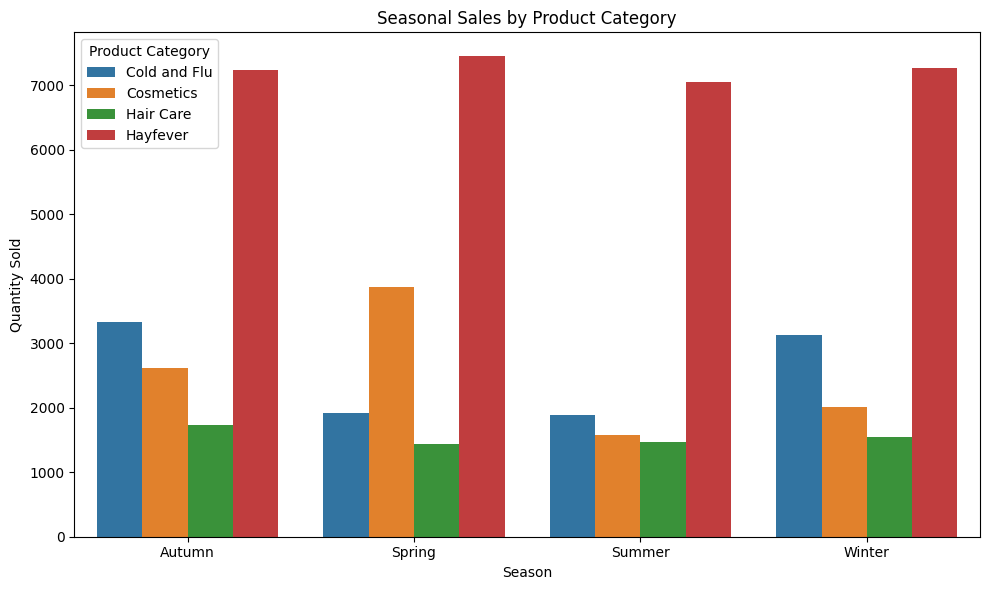

In [19]:
# Insight 2: Total sales by season
seasonal_sales = sales_df.groupby(['Season', 'Product Category'])['Quantity Sold'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_sales, x='Season', y='Quantity Sold', hue='Product Category')
plt.title('Seasonal Sales by Product Category')
plt.tight_layout()
plt.show()